In [1]:
import numpy as np
import random
from grid_world_5x5 import *
import matplotlib.pyplot as plt

In [2]:
# 0 - Left ; 1 - Down ; 2 - Right ; 3 - Up

In [3]:
# Agent trained for 20 trajectories
sample_grid = MyGridWorld()
sample_grid_trainer = MyGridWorldTrainer()
sample_trajectories = sample_grid_trainer.all_in_one(sample_grid, 20)     # training (Q Learning)

print('Policy: \n')
for direction in sample_grid_trainer.matrix:
    print(direction)

print('\nPolicy (directions): \n')
for row in sample_grid_trainer.DirectionalMatrix:
    print(row)

print('\nQ value matrix: \n')
for row in sample_grid_trainer.Q:   # Q value for each state action pair
    print(row)

print('\nTrajectories: \n')
for trajectory in sample_trajectories:
    print(trajectory)

Policy: 

[2 2 2 2 0]
[3 2 3 3 3]
[2 3 2 2 3]
[3 3 2 2 3]
[2 2 3 3 3]

Policy (directions): 

['→', '→', '→', '→', '←']
['↑', '→', '↑', '↑', '↑']
['→', '↑', '→', '→', '↑']
['↑', '↑', '→', '→', '↑']
['→', '→', '↑', '↑', '↑']

Q value matrix: 

[0.34330894 0.36055157 0.60288997 0.34112582]
[0.42487965 0.41958712 0.73501281 0.41938391]
[0.43857516 0.45532449 0.86006871 0.4606382 ]
[0.54368061 0.54917266 0.98900719 0.56070794]
[0. 0. 0. 0.]
[0.31741228 0.30683214 0.32511956 0.50656616]
[0.35258707 0.3459392  0.64723042 0.36003652]
[0.43765567 0.41459173 0.42189972 0.74540799]
[0.50432418 0.54888295 0.5425122  0.78892056]
[0.57172339 0.55858649 0.57565364 0.87569552]
[0.25939126 0.26065254 0.44674329 0.25811935]
[0.31424648 0.31341877 0.31742303 0.55070258]
[0.36561448 0.3289714  0.66808385 0.33345741]
[0.42433023 0.40712863 0.65105435 0.40849141]
[0.46466908 0.44190578 0.46957498 0.78411511]
[0.25854245 0.26064842 0.26293369 0.42658218]
[0.28901321 0.28941119 0.29659478 0.44465018]
[0.3257

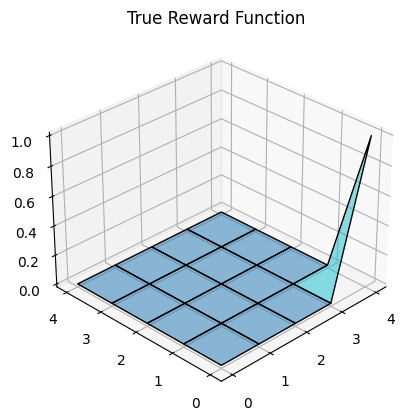

In [4]:
# function for plotting reward function
def plot_reward_function(reward, title=''):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    x = y = np.arange(0, 5, 1)
    X, Y = np.meshgrid(x, y)
    zs = reward  # True reward function
    Z = zs.reshape(X.shape)

    ax.view_init(30, -135)
    ax.plot_surface(X, Y, Z, alpha=0.5, cmap='tab10', rstride=1, cstride=1, edgecolors='k', lw=1)

    ax.set_title(title)

    plt.show()

# plot true reward function
plot_reward_function(sample_grid_trainer.env.RewardGrid, 'True Reward Function')

In [5]:
# function to generate transition matrix

def construct_transition_matrix(size=5, states=25, actions=4, noisy_move_chance=0.3):
    transition_matrix = np.zeros([states, states, actions])

    for state in range(states):
        for action in range(actions):
            i = int(state / size)
            j = state % size

            prob_stay = 1     # probability of staying in the current state

            # updating transition probabilities based on the chosen action
            if action == 0:  # Left
                if 0 < j:    # not at the left edge of the grid
                    prob_stay = prob_stay - (1 - noisy_move_chance)   # (1 - noisy_move_chance) = probability of a deterministic transition
                    j2 = j - 1      # update col index
                    transition_matrix[state][int(i * size + j2)][action] = 1 - noisy_move_chance    # int(i * size + j2) = index of the resulting state

            elif action == 1:  # Down
                if i < size - 1:
                    prob_stay = prob_stay - (1 - noisy_move_chance)
                    i2 = i + 1
                    transition_matrix[state][int(i2 * size + j)][action] = 1 - noisy_move_chance

            elif action == 2:  # Right
                if j < size - 1:
                    prob_stay = prob_stay - (1 - noisy_move_chance)
                    j2 = j + 1
                    transition_matrix[state][int(i * size + j2)][action] = 1 - noisy_move_chance

            elif action == 3:  # Up
                if 0 < i:
                    prob_stay = prob_stay - (1 - noisy_move_chance)
                    i2 = i - 1
                    transition_matrix[state][int(i2 * size + j)][action] = 1 - noisy_move_chance

            # updating transition probabilities based on the noisy actions (stochastic behavior)
            if 0 < j:
                prob_stay = prob_stay - (noisy_move_chance / 4)       # since 4 possible actions
                j2 = j - 1
                transition_matrix[state][int(i * size + j2)][action] += (noisy_move_chance / 4)

            if i < size - 1:
                prob_stay = prob_stay - (noisy_move_chance / 4)
                i2 = i + 1
                transition_matrix[state][int(i2 * size + j)][action] += (noisy_move_chance / 4)

            if j < size - 1:
                prob_stay = prob_stay - (noisy_move_chance / 4)
                j2 = j + 1
                transition_matrix[state][int(i * size + j2)][action] += (noisy_move_chance / 4)

            if 0 < i:
                prob_stay = prob_stay - (noisy_move_chance / 4)
                i2 = i - 1
                transition_matrix[state][int(i2 * size + j)][action] += (noisy_move_chance / 4)

            # probability of staying too small
            if prob_stay < 10**-15:
                prob_stay = 0
            transition_matrix[state][state][action] = prob_stay

    return transition_matrix

In [6]:
# 'Given' optimal policy
optimum_policy = [[2, 2, 2, 2, 2],
                 [3, 2, 2, 3, 3],
                 [3, 3, 3, 3, 3],
                 [3, 3, 2, 3, 3],
                 [3, 2, 2, 2, 3]]

# Directional matrix of given optimal policy
directional_matrix = []

for i in range(5):
    row = []
    for j in range(5):
        if optimum_policy[i][j] == 0:
            row.append('\u2190')  # Left arrow
        elif optimum_policy[i][j] == 1:
            row.append('\u2193')  # Down arrow
        elif optimum_policy[i][j] == 2:
            row.append('\u2192')  # Right arrow
        elif optimum_policy[i][j] == 3:
            row.append('\u2191')  # Up arrow
    directional_matrix.append(row)

print('Given Optimal Policy: \n')
for row in directional_matrix:
    print(row)

Given Optimal Policy: 

['→', '→', '→', '→', '→']
['↑', '→', '→', '↑', '↑']
['↑', '↑', '↑', '↑', '↑']
['↑', '↑', '→', '↑', '↑']
['↑', '→', '→', '→', '↑']


In [7]:
from scipy.optimize import linprog    # for linear programming

In [8]:
# linear programming approach for solving the inverse reinforcement learning problem (returns the reward function for given policy)

def perform_inverse_reinforcement_learning(policy, gamma=0.5, l1=10):
    trans_probs = construct_transition_matrix(size=5, states=25, actions=4, noisy_move_chance=0.3)
    conditions = []
    c = np.zeros([3 * 25])    # coefficients

    for i in range(25):
        optimal_action = policy[i]      # a1
        temp_trans_prob_matrix = gamma * trans_probs[:, :, optimal_action]      # γ⋅Pa1
        temp_inverse = np.linalg.inv(np.identity(25) - temp_trans_prob_matrix)  # (I−γ⋅Pa1​)^−1

        for j in range(4):
            if j != optimal_action:
                condition = -np.dot(trans_probs[i, :, optimal_action] - trans_probs[i, :, j], temp_inverse)   # (Pa1​−Pa​)(I−γ⋅Pa1​)^−1
                conditions.append(condition)

    equality = np.zeros(625)    # 625 equality constraints in the lp problem
    c[25:2 * 25] = -1           # ensure that rewards for non-optimal actions are negative
    c[2 * 25:] = l1             # regularization term

    conditions = np.array(conditions)   # contains coefficients
    conditions = np.reshape(conditions, [625, 75])      # 75 coefficients
    print(len(c), conditions.shape)
    rewards = linprog(c, A_ub=conditions, b_ub=equality)

    return rewards

75 (625, 75)


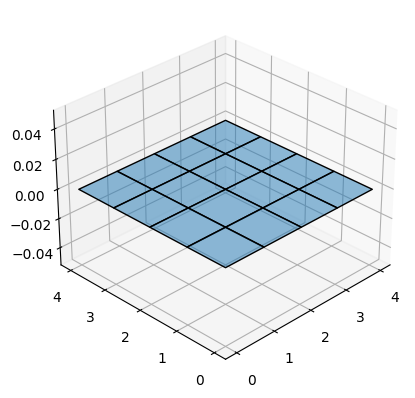

In [9]:
policy = np.reshape(sample_grid_trainer.matrix,[25,1])
# policy = np.reshape(optimum_policy,[25,1])

reward = perform_inverse_reinforcement_learning(policy,gamma=0.5,l1=1)
reward = reward['x'][:25]
reward = np.reshape(reward,[5,5])

plot_reward_function(reward)    # we get a degenerate reward function

In [10]:
from cvxopt import matrix, solvers

In [11]:
# function to set up the constraints and variables for the linear programming problem

def initialize_solver_matrix(penalty=10):
    # For all states and all possible non-optimal actions to all states

    A = np.zeros([25**2, 3 * 25])     # linear inequality constraints
    b = np.zeros([25**2])             # right-hand side values for the linear constraints
    x = np.zeros([3 * 25])            # variables

    def initialize():
        size = 25
        num = 150   #offset
        i = 0

        while i < 25:
            A[num + i, i] = 1
            A[num + size + i, i] = -1

            j = 2
            while j < 4:
                A[num + j * size + i, i] = 1
                A[num + j * size + i, 2 * size + i] = -1
                j += 1

            b[num + i] = 1
            b[num + size + i] = 0
            i += 1

    initialize()

    x[25:] = -1
    x[-25:] = penalty

    return A, b, x

In [12]:
# optimization step for inverse reinforcement learning
# aims to maximize the rewards associated with optimal actions and penalize non-optimal actions

def perform_optimized_IRL(policy, gamma=0.5, penalty=10):
    TransitionMatrix = construct_transition_matrix()

    A, b, x = initialize_solver_matrix(penalty)
    i = 0

    while i < 25:
        optimalAction = int(policy[i])
        tempTransProbMatrix = gamma * TransitionMatrix[:, :, optimalAction]           # γ⋅Pa1
        patialInvertedMatrix = np.linalg.inv(np.identity(25) - tempTransProbMatrix)   #(I−γ⋅Pa1​)^−1

        temp = 0
        j = 0

        while j < 4:
            if j != optimalAction:      # penalize non-optimal actions
                otherPartialMatrix = TransitionMatrix[i, :, optimalAction] - TransitionMatrix[i, :, j]  # Pa1​−Pa
                val = -np.dot(otherPartialMatrix, patialInvertedMatrix)       # (Pa1​−Pa​)(I−γ⋅Pa1​)^−1
                pos = 25 * 3                        # starting index for the additional set of constraints related to the penalty term
                A[i * 3 + temp, :25] = val          # constraints associated with the reward vector for state i and the observed optimal action
                A[pos + i * 3 + temp, :25] = val    # constraints associated with the penalty term.
                A[pos + i * 3 + temp, 25 + i] = 1   # additional constraint to enforce the penalty term in the linear programming problem.
            else:
                temp = temp - 1
            temp = temp + 1
            j = j + 1
        i = i + 1

    x = matrix(x)
    A = matrix(A)
    b = matrix(b)

    return solvers.lp(x, A, b)

In [13]:
# perform IRL to obtain reward function

policy = np.reshape(optimum_policy, [25, 1])

rewards = perform_optimized_IRL(policy, gamma=0.1, penalty=1.05)
rewards = rewards['x']
rewards = rewards[:5 * 5]
rewards = rewards / max(rewards)      # normalize the rewards
rewards = np.reshape(rewards, [5, 5])

true = np.abs(sample_grid_trainer.env.RewardGrid)   # true rewards
obtained = np.abs(rewards)                          # estimated rewards
errors = true - obtained

error = np.abs(np.sum(np.sum(errors)))
print('\nError: \n',error)

     pcost       dcost       gap    pres   dres   k/t
 0:  1.3125e+01 -3.1742e+01  1e+03  5e+00  7e+00  1e+00
 1: -9.1001e-01 -1.3208e+01  2e+02  1e+00  2e+00  1e+00
 2: -3.8381e-01 -2.1218e+00  2e+01  2e-01  4e-01  6e-01
 3: -4.4051e-01 -1.2314e+00  8e+00  1e-01  2e-01  2e-01
 4: -4.2609e-01 -6.7149e-01  2e+00  3e-02  5e-02  4e-02
 5: -4.1735e-01 -5.0245e-01  7e-01  1e-02  1e-02  8e-03
 6: -4.3122e-01 -4.5420e-01  2e-01  3e-03  4e-03  2e-03
 7: -4.3303e-01 -4.4052e-01  6e-02  9e-04  1e-03  4e-04
 8: -4.3247e-01 -4.3587e-01  3e-02  4e-04  6e-04  9e-05
 9: -4.3246e-01 -4.3335e-01  7e-03  1e-04  1e-04  2e-05
10: -4.3232e-01 -4.3270e-01  3e-03  4e-05  6e-05  6e-06
11: -4.3226e-01 -4.3234e-01  7e-04  9e-06  1e-05  1e-06
12: -4.3224e-01 -4.3226e-01  2e-04  3e-06  4e-06  4e-07
13: -4.3223e-01 -4.3224e-01  5e-05  6e-07  9e-07  9e-08
14: -4.3223e-01 -4.3223e-01  1e-05  1e-07  2e-07  2e-08
15: -4.3223e-01 -4.3223e-01  9e-07  1e-08  2e-08  1e-09
16: -4.3223e-01 -4.3223e-01  5e-08  7e-10  1e-09  

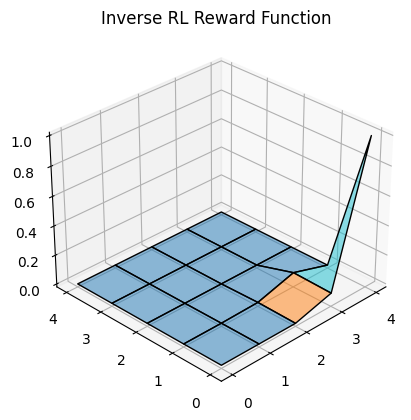

In [14]:
plot_reward_function(rewards, 'Inverse RL Reward Function')

     pcost       dcost       gap    pres   dres   k/t
 0:  3.1250e+01 -3.1488e+01  2e+03  5e+00  6e+00  1e+00
 1:  1.1318e+00 -1.2052e+01  2e+02  1e+00  1e+00  8e-01
 2:  1.8804e-01 -1.0581e+00  1e+01  1e-01  1e-01  2e-01
 3:  4.3245e-03 -1.1506e-02  2e-01  1e-03  2e-03  2e-03
 4:  4.3189e-05 -1.1494e-04  2e-03  1e-05  2e-05  2e-05
 5:  4.3188e-07 -1.1494e-06  2e-05  1e-07  2e-07  2e-07
 6:  4.3188e-09 -1.1494e-08  2e-07  1e-09  2e-09  2e-09
 7:  4.3188e-11 -1.1494e-10  2e-09  1e-11  2e-11  2e-11
Optimal solution found.


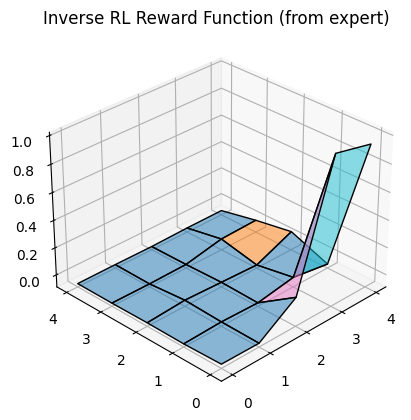

In [30]:
policy = np.reshape(sample_grid_trainer.matrix, [25, 1])

rewards = perform_optimized_IRL(policy, gamma=0.1, penalty=2.5)
rewards = rewards['x']
rewards = rewards[:5 * 5]
rewards = rewards / max(rewards)
rewards = np.reshape(rewards, [5, 5])

plot_reward_function(rewards, 'Inverse RL Reward Function (from expert)')